In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.sql.functions import *
from pyspark.mllib.evaluation import MulticlassMetrics
import pyspark.sql.functions as F
from pyspark.ml.classification import LinearSVC



In [2]:
%pip install sparkxgb
# Pour XGBoost

from sparkxgb.xgboost import XGBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns


[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: C:\Users\ibrah\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [3]:
import findspark
findspark.init()
import os

# Create temp directory for Spark
temp_dir = os.path.join(os.getcwd(), "spark_temp")
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)


In [4]:
# Then modify your Spark session configuration to include XGBoost
spark = SparkSession.builder \
    .appName("TweetClassification") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "4") \
    .config("spark.local.dir", temp_dir) \
    .config("spark.jars.packages", "ml.dmlc:xgboost4j-spark_2.12:1.7.1,ml.dmlc:xgboost4j_2.12:1.7.1") \
    .getOrCreate()

In [5]:
# 1. IDENTIFICATION ET COLLECTE DES DONNÉES
print("1. Chargement et analyse initiale des données")
print("-" * 50)


1. Chargement et analyse initiale des données
--------------------------------------------------


In [6]:
# Chargement des données
train_df = spark.read.csv('../data/train_tweets.csv', header=True)
test_df = spark.read.csv('../data/test_tweets.csv', header=True)

In [7]:
# Analyse exploratoire des données
print("Aperçu du jeu de données:")
train_df.show(5)
print("\nSchéma des données:")
train_df.printSchema()


Aperçu du jeu de données:
+------------------+--------+--------------------+
|           TweetId|   Label|           TweetText|
+------------------+--------+--------------------+
|304271250237304833|Politics|'#SecKerry: The v...|
|304834304222064640|Politics|'@rraina1481 I fe...|
|303568995880144898|  Sports|'Watch video high...|
|304366580664528896|  Sports|'RT @chelscanlan:...|
|296770931098009601|  Sports|'@cricketfox Alwa...|
+------------------+--------+--------------------+
only showing top 5 rows


Schéma des données:
root
 |-- TweetId: string (nullable = true)
 |-- Label: string (nullable = true)
 |-- TweetText: string (nullable = true)



In [8]:
# Statistiques descriptives
print("\nStatistiques des données:")
print(f"Nombre total d'échantillons: {train_df.count()}")


Statistiques des données:
Nombre total d'échantillons: 6525


In [9]:
print("\nDistribution des classes:")
train_df.groupBy("Label").count().show()


Distribution des classes:
+--------+-----+
|   Label|count|
+--------+-----+
|Politics| 3200|
|  Sports| 3325|
+--------+-----+



In [10]:
# Vérification des valeurs manquantes
print("\nVérification des valeurs manquantes:")
for column in train_df.columns:
    null_count = train_df.filter(col(column).isNull()).count()
    print(f"{column}: {null_count} valeurs manquantes")


Vérification des valeurs manquantes:
TweetId: 0 valeurs manquantes
Label: 0 valeurs manquantes
TweetText: 0 valeurs manquantes


In [11]:
# 2. PRÉTRAITEMENT DES DONNÉES
print("\n2. Prétraitement des données")
print("-" * 50)


2. Prétraitement des données
--------------------------------------------------


In [12]:
# Nettoyage du texte
def clean_text(df):
    return df.withColumn("cleaned_text", 
        regexp_replace(lower(col("TweetText")), "[^a-zA-Z\\s]", " "))

In [13]:
train_df = clean_text(train_df)

In [14]:
# Pipeline de prétraitement
# 1. Conversion des labels en indices
labelIndexer = StringIndexer(inputCol="Label", outputCol="label")

In [15]:
# 2. Tokenization
tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="words")

In [16]:
# 3. Suppression des stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

In [17]:
# 4. Vectorisation TF
countVectorizer = CountVectorizer(inputCol="filtered_words", outputCol="tf", minDF=2.0)

In [18]:
# 5. IDF
idf = IDF(inputCol="tf", outputCol="features")

In [19]:
# Création du pipeline
preprocessing_pipeline = Pipeline(stages=[
    labelIndexer,
    tokenizer,
    remover,
    countVectorizer,
    idf
])

In [20]:
# Division des données
train_data, val_data = train_df.randomSplit([0.8, 0.2], seed=42)

In [21]:
# Application du pipeline
pipeline_model = preprocessing_pipeline.fit(train_data)
train_processed = pipeline_model.transform(train_data)
val_processed = pipeline_model.transform(val_data)

In [22]:
# 3. DÉVELOPPEMENT DES MÉTHODES D'APPRENTISSAGE
print("\n3. Entraînement des modèles")
print("-" * 50)


3. Entraînement des modèles
--------------------------------------------------


In [23]:
# Logistic Regression
lr = LogisticRegression(maxIter=20)
lr_model = lr.fit(train_processed)

In [24]:
# Random Forest
rf = RandomForestClassifier(numTrees=10)
rf_model = rf.fit(train_processed)

In [25]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: C:\Users\ibrah\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [27]:
# XGBoost
xgb = XGBoostClassifier(
    numRound=100,
    featuresCol="features",
    labelCol="label", 
    missing=0.0
)
xgb_model = xgb.fit(train_processed)

In [33]:
# Support Vector Machine
svm = LinearSVC(maxIter=10, 
                regParam=0.1,
                featuresCol="features",
                labelCol="label")
svm_model = svm.fit(train_processed)

In [28]:
# 4. ÉVALUATION DES PERFORMANCES
print("\n4. Évaluation des performances")
print("-" * 50)


4. Évaluation des performances
--------------------------------------------------


In [29]:
from sklearn.metrics import confusion_matrix


def evaluate_model(model, data, model_name):
    predictions = model.transform(data)
    
    # Métriques de classification
    evaluator_acc = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="accuracy"
    )
    
    evaluator_f1 = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="f1"
    )
    
    evaluator_precision = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedPrecision"
    )
    
    evaluator_recall = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedRecall"
    )
    
    accuracy = evaluator_acc.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)
    precision = evaluator_precision.evaluate(predictions)
    recall = evaluator_recall.evaluate(predictions)
    
    print(f"\nRésultats pour {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    # Matrice de confusion
    predictions_pd = predictions.select("label", "prediction").toPandas()
    conf_matrix = confusion_matrix(predictions_pd["label"], predictions_pd["prediction"])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrice de confusion - {model_name}')
    plt.ylabel('Vraie classe')
    plt.xlabel('Prédiction')
    plt.show()
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [30]:
# Évaluation des modèles
results = []


Résultats pour Logistic Regression:
Accuracy: 0.9181
F1-Score: 0.9181
Precision: 0.9181
Recall: 0.9181


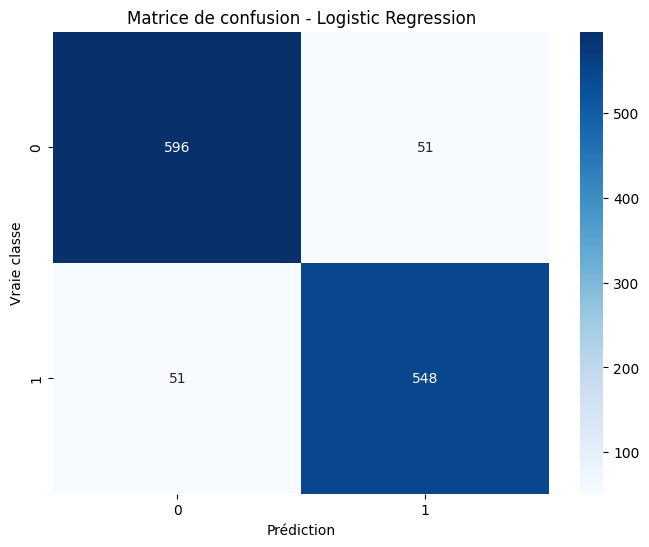


Résultats pour Random Forest:
Accuracy: 0.7159
F1-Score: 0.7152
Precision: 0.7161
Recall: 0.7159


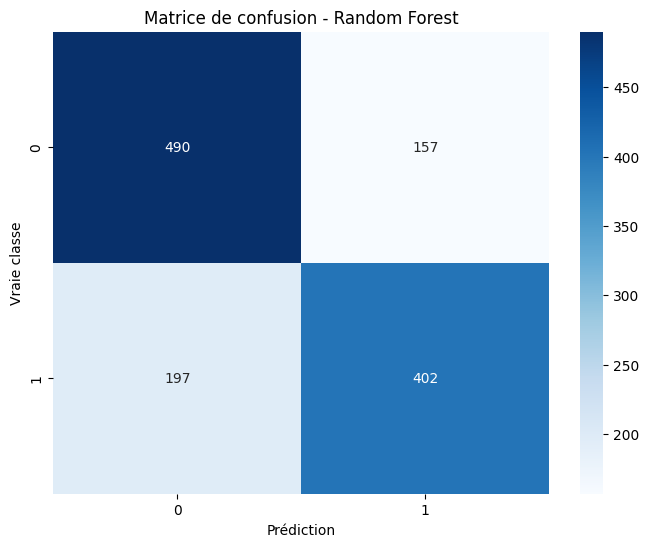


Résultats pour XGBoost:
Accuracy: 0.8965
F1-Score: 0.8963
Precision: 0.8971
Recall: 0.8965


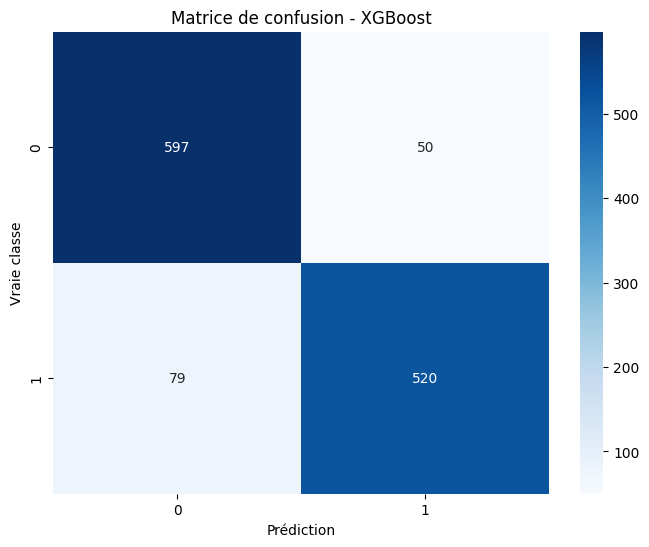


Résultats pour Support Vector Machine:
Accuracy: 0.9446
F1-Score: 0.9446
Precision: 0.9448
Recall: 0.9446


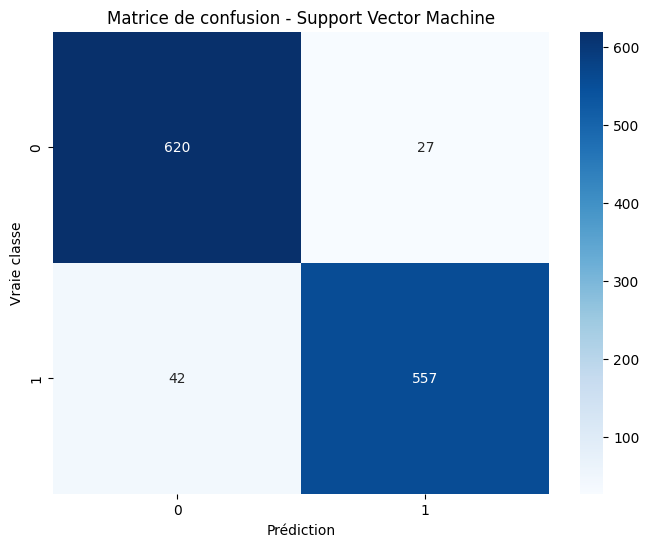

In [34]:
results.append(evaluate_model(lr_model, val_processed, "Logistic Regression"))
results.append(evaluate_model(rf_model, val_processed, "Random Forest"))
results.append(evaluate_model(xgb_model, val_processed, "XGBoost"))
results.append(evaluate_model(svm_model, val_processed, "Support Vector Machine"))


In [35]:
import pandas as pd

# Comparaison des modèles
results_df = pd.DataFrame(results)
metrics = ['accuracy', 'f1', 'precision', 'recall']

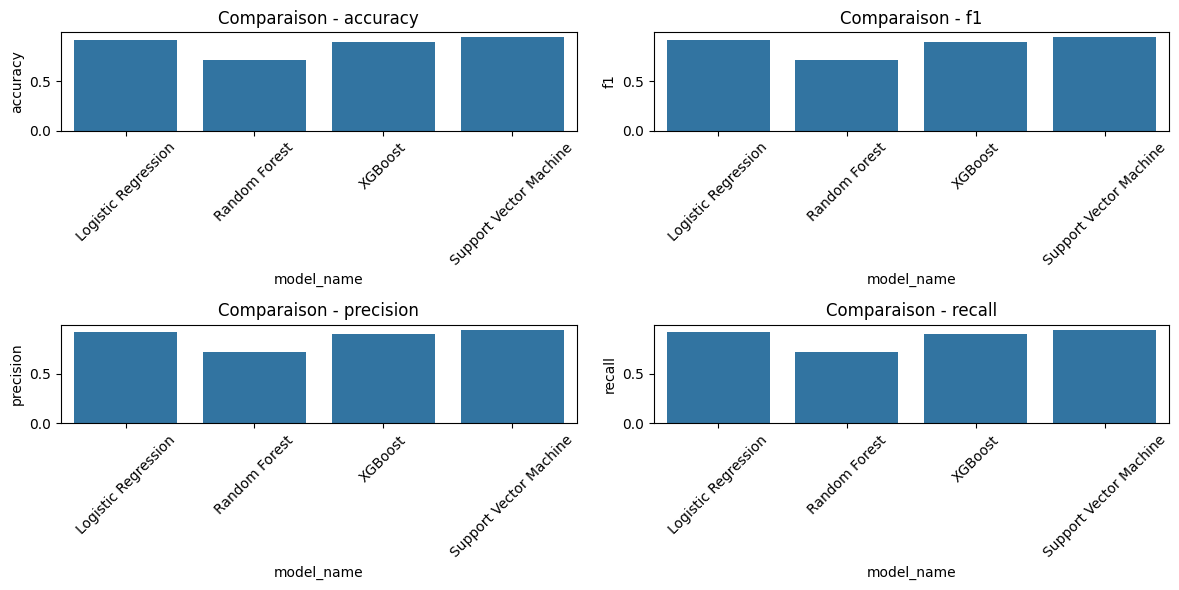

In [36]:
plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='model_name', y=metric, data=results_df)
    plt.title(f'Comparaison - {metric}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
# Sélection du meilleur modèle
best_model = results_df.loc[results_df['f1'].idxmax()]
print("\nMeilleur modèle:")
print(f"Modèle: {best_model['model_name']}")
print(f"F1-Score: {best_model['f1']:.4f}")



Meilleur modèle:
Modèle: Support Vector Machine
F1-Score: 0.9446
